In [63]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Layer, Embedding, GRU, Dense, AdditiveAttention

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pathlib

**Shape Checker**

In [59]:
class ShapeChecker:
    def __init__(self):
        self.shapes = {}
        
    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return
        
        # check whether it is a string
        if isinstance(names, str):
            names = (names,)
            
        shape = tf.shape(tensor)
        rank = tf.rank(tensor)
        
        if rank != len(names):
            raise ValueError(f'Rank mismatch:\n'
                             f'    found {rank}: {shape.numpy()}\n'
                             f'    expected {len(names)}: {names}\n')
        
        for i, name in enumerate(names):
            if isinstance(name, int):
                old_dim = name
            else:
                old_dim = self.shapes.get(name, None)
            new_dim = shape[i]

            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue
            
            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                 f"    found: {new_dim}\n"
                                 f"    expected: {old_dim}\n")
                            

In [44]:
a = [[1,2],[3,4],[5,6]]
tf.rank(a)

<tf.Tensor: shape=(), dtype=int32, numpy=2>

**Download Dataset**  

In [9]:
path_to_zip = tf.keras.utils.get_file('spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', extract=True)
path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [22]:
def load_data(path):
    text = path.read_text(encoding='utf-8')
    
    # lines[0] = 'Go.\tVe.'
    lines = text.splitlines()
    # pairs[0] = ['Go.', 'Ve.']
    pairs = [line.split('\t') for line in lines]

    inp = [inp for targ, inp in pairs]
    targ = [targ for targ, inp in pairs]

    return targ, inp

In [23]:
# targ: english
# inp: spanish
targ, inp = load_data(path_to_file)

In [24]:
print(inp[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [25]:
print(targ[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


In [27]:
# create a tf.data.Dataset of strings that shuffles and batches them efficiently
BUFFER_SIZE = len(inp)
BATCH_SIZE = 32

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [28]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5])
    print()
    print(example_target_batch[:5])
    break

tf.Tensor(
[b'No estamos haciendo nada.' b'Est\xc3\xa1s gordo.'
 b'Tom triplic\xc3\xb3 su inversi\xc3\xb3n en seis meses.'
 b'No nos gusta la lluvia.' b'Hoy es once de octubre.'], shape=(5,), dtype=string)

tf.Tensor(
[b"We're doing nothing." b"You're gross!"
 b'Tom tripled his investment in six months.' b"We don't like the rain."
 b'Today is October 11th.'], shape=(5,), dtype=string)


**Text Preprocessing**

In [31]:
# i) Standardization
# Unicode normalization - split accented characters and replace compatibility characters with their ASCII equivalents
def tf_lower_and_split_punct(text):
    # Split accecented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [33]:
# demo
example_text = tf.constant('i love apple#!')
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

i love apple#!
[START] i love apple ! [END]


In [34]:
# ii) Text Vectoriaztion (encoding)
max_vocab_size = 5000

input_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

In [35]:
# Spanish TextVectorization layer
input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [36]:
# English TextVectorization layer
output_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [38]:
# demo 
# these layers can convert a batch of strings into a batch of token IDs
print(example_text.numpy().decode())
example_tokens = output_text_processor(example_text)
print(example_tokens)

i love apple#!
tf.Tensor([  2   6 155 800 119   3], shape=(6,), dtype=int64)


In [51]:
# demo
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,    9,  172,  246,   69,    4,    3,    0,    0,    0],
       [   2,   76, 1720,    4,    3,    0,    0,    0,    0,    0],
       [   2,   10,    1,   25,    1,   14,  405,  796,    4,    3]],
      dtype=int64)>

In [52]:
# get_vocabulary method can be used to convert token IDs back to text
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] no estamos haciendo nada . [END]      '

Text(0.5, 1.0, 'Mask')

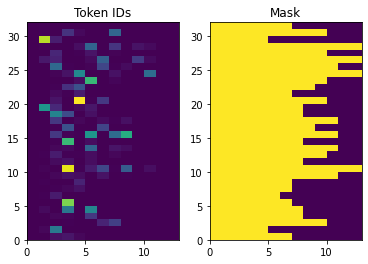

In [53]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

**Encoder**

In [39]:
embedding_dim = 256
units = 1024

In [56]:
class Encoder(Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size
        self.embedding = Embedding(self.input_vocab_size, embedding_dim)
        self.gru = GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        
    def call(self, tokens, state=None):
        shape_checker = ShapeChecker()
        shape_checker(tokens, ('batch', 's'))
        
        vectors = self.embedding(tokens)
        shape_checker(vectors, ('batch', 's', 'embed_dim'))
        
        # output shape: (batch, s, enc_units)
        # state shape: (batch, enc_units)
        output, state = self.gru(vectors, initial_state=state)
        shape_checker(output, ('batch', 's', 'enc_units'))
        shape_checker(state, ('batch', 'enc_units'))
        
        return output, state

In [60]:
# demo
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(), embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (32,)
Input batch tokens, shape (batch, s): (32, 13)
Encoder output, shape (batch, s, units): (32, 13, 1024)
Encoder state, shape (batch, units): (32, 1024)


**Attention Head**

In [64]:
class BahdanauAttention(Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = Dense(units, use_bias=False)
        self.W2 = Dense(units, use_bias=False)
        self.attention = AdditiveAttention()
        
    def call(self, query, value, mask):
        def call(self, query, value, mask):
            shape_checker = ShapeChecker()
            shape_checker(query, ('batch', 't', 'query_units'))
            shape_checker(value, ('batch', 's', 'value_units'))
            shape_checker(mask, ('batch', 's'))

            # From Eqn. (4), `W1@ht`.
            w1_query = self.W1(query)
            shape_checker(w1_query, ('batch', 't', 'attn_units'))

            # From Eqn. (4), `W2@hs`.
            w2_key = self.W2(value)
            shape_checker(w2_key, ('batch', 's', 'attn_units'))

            query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
            value_mask = mask

            context_vector, attention_weights = self.attention(
                inputs = [w1_query, value, w2_key],
                mask=[query_mask, value_mask],
                return_attention_scores = True,
            )
            shape_checker(context_vector, ('batch', 't', 'value_units'))
            shape_checker(attention_weights, ('batch', 't', 's'))

            return context_vector, attention_weights 